# Long Short-Term Memory (LSTM)

<div style="text-align:justify">
Long Short-Term Memory (LSTM) é uma Rede Neural Recorrente capaz de aprender longas sequências de observações. Neste exemplo vamos desenvolver um modelo LSTM para um problema de previsão de séries temporais univariadas de uma etapa.
</div>

### Carregando Pacotes

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy

from matplotlib import pyplot
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 6

<div style="text-align:justify">
O dataset utilizado neste exemplo descreve o número mensal de vendas de shampoo ao longo de um período de 3 anos. As unidades são uma contagem de vendas e existem 36 observações. O conjunto de dados original é creditado a Makridakis, Wheelwright e Hyndman (1998).
<br><br>
O exemplo abaixo carrega e cria um gráfico do conjunto de dados carregado.
</div>

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


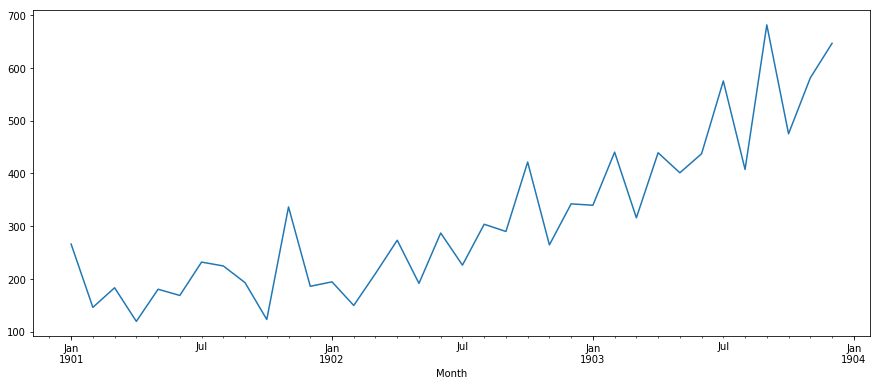

In [3]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

### Baseline

<div style="text-align:justify">
Para configurar nosso baseline vamos dividir o conjunto de dados do Shampoo Sales em duas partes: Treinamento e teste. Os dois primeiros anos de dados serão dados para treinamento e o ano restante de dados será usado para testes.
</div>

In [4]:
# split data into train and test-sets
X = series.values
train, test = X[0:-12], X[-12:]

<div style="text-align:justify">
O modelo será desenvolvido usando o conjunto de dados de treinamento e farão previsões no conjunto de dados de teste. Um cenário de previsão contínua será usado, também chamado de validação do modelo de walk-forward.
<br><br>
Cada etapa de tempo do conjunto de dados de teste será percorrida um de cada vez. Um modelo será usado para fazer uma previsão para a etapa de tempo, então o valor real esperado do conjunto de testes será obtido e disponibilizado para o modelo para a previsão na próxima etapa de tempo.
<br><br>
Isso imita um cenário do mundo real em que as novas observações de vendas do Shampoo estariam disponíveis a cada mês e usadas na previsão do mês seguinte.
</div>

### Walk-forward

<div style="text-align:justify">
Uma boa previsão de baseline para uma série temporal com uma tendência crescente linear é uma previsão de persistência. A previsão de persistência é onde a observação da etapa de tempo anterior (t-1) é usada para prever a observação na etapa de tempo atual (t).
<br><br>
Podemos implementar isso tirando a última observação dos dados de treinamento e histórico acumulado pela validação de walk-forward e usando isso para prever o passo de tempo atual.
</div>

RMSE: 136.761


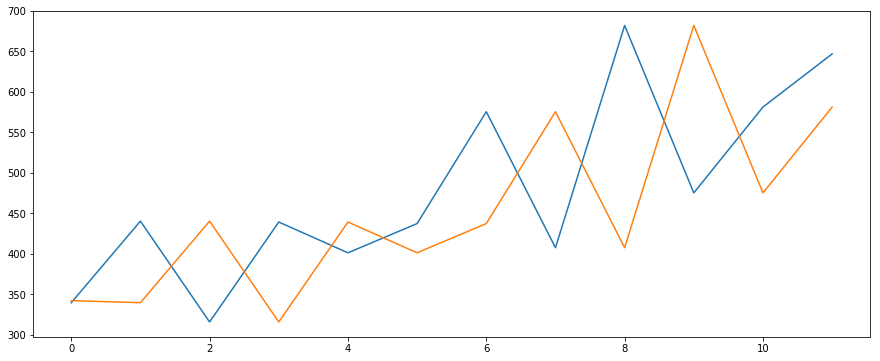

In [5]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

### Preparação de dados LSTM

Antes de ajustar um modelo LSTM ao conjunto de dados, devemos transformar os dados. Esta seção é dividida em três etapas:

- Transformar a série temporal em um problema de aprendizado supervisionado
- Transformar os dados da série temporal para que fiquem parados.
- Transformar as observações para ter uma escala específica.

<div style="text-align:justify">
O modelo LSTM em Keras assume que seus dados são divididos em componentes de entrada (X) e saída (y). Para um problema de série temporal, podemos conseguir isso usando a observação do último intervalo de tempo (t-1) como a entrada e a observação no passo de tempo atual (t) como a saída.
<br><br>
Podemos conseguir isso usando a função shift () em Pandas, que empurra todos os valores em uma série para baixo por um número especificado de lugares. Nós exigimos um deslocamento de 1 lugar, que se tornará as variáveis de entrada. A série temporal, tal como está, será a variável de saída.
<br><br>
Podemos, então, concatenar essas duas séries juntas para criar um DataFrame pronto para o aprendizado supervisionado. A série pushdown terá uma nova posição no topo sem valor. Um valor NaN (não um número) será usado nesta posição. Substituiremos esses valores NaN por valores 0, que o modelo LSTM terá que aprender como "o início da série" ou "Não tenho dados aqui", pois um mês com vendas zero neste conjunto de dados não foi observado.
<br><br>
O código abaixo define uma função auxiliar para fazer isso chamado timeseries_to_supervised (). Ele usa uma matriz NumPy dos dados da série temporal bruta e um atraso ou número de séries deslocadas para criar e usar como entradas.
</div>

In [6]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [7]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


Podemos testar essa função com nosso conjunto de dados Shampoo Sales carregado e convertê-lo em um problema de aprendizado supervisionado.

### Transformar Séries Temporais em Estacionárias

<div style="text-align:justify">
O conjunto de dados do Shampoo Sales não é estacionário. Isso significa que há uma estrutura nos dados que depende do tempo. Especificamente, há uma tendência crescente nos dados. Dados estacionários são mais fáceis de modelar e muito provavelmente resultarão em previsões melhores.
<br><br>
A tendência pode ser removida das observações, depois incluída novamente nas previsões para retornar a previsão à escala original e calcular uma pontuação de erro comparável.
<br><br>
Uma maneira padrão de remover uma tendência é diferenciar os dados. Essa é a observação do passo de tempo anterior (t-1) é subtraída da observação atual (t). Isso remove a tendência e ficamos com uma série de diferenças, ou as mudanças nas observações de um passo para o outro.
<br><br>
Podemos conseguir isso automaticamente usando a função diff() em pandas. Alternativamente, podemos obter um controle mais refinado e escrever nossa própria função para fazer isso, o que é preferível por sua flexibilidade neste caso.
<br><br>
Abaixo está uma função chamada difference() que calcula uma série diferenciada. Observe que a primeira observação na série é ignorada, pois não há observação prévia com a qual calcular um valor diferenciado.
</div>

In [8]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

<div style="text-align:justify">
Também precisamos inverter esse processo para levar as previsões feitas nas séries diferenciadas de volta à sua escala original. A função abaixo, chamada inversse_difference (), inverte esta operação.
</div>

In [9]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

Podemos testar essas funções diferenciando toda a série e retornando-a à escala original, da seguinte maneira:

In [10]:
print(series.head())

# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)

inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


<div style="text-align:justify">
A execução do exemplo imprime as 5 primeiras linhas dos dados carregados, depois as 5 primeiras linhas das séries diferenciadas e, finalmente, as 5 primeiras linhas com a operação de diferença invertida. Observe que a primeira observação no conjunto de dados original foi removida dos dados de diferença invertida. Além disso, o último conjunto de dados corresponde ao primeiro como esperado.
</div>

### Ajustando a Escala

<div style="text-align:justify">
Como outras redes neurais, os LSTMs esperam que os dados estejam dentro da escala da função de ativação usada pela rede. A função de ativação padrão para LSTMs é a tangente hiperbólica (tanh), que produz valores entre -1 e 1. Esse é o intervalo preferido para os dados da série temporal.
<br><br>
Para tornar o experimento justo, os valores dos coeficientes de escala (mínimo e máximo) devem ser calculados no conjunto de dados de treinamento e aplicados para dimensionar o conjunto de dados de teste e as previsões. Isso evita contaminar o experimento com conhecimento do conjunto de dados de teste, o que pode dar ao modelo uma pequena vantagem.
<br><br>
Podemos transformar o conjunto de dados no intervalo [-1, 1] usando a classe MinMaxScaler. Como outras classes de transformação scikit-learn, ele requer dados fornecidos em um formato de matriz com linhas e colunas. Portanto, devemos reformular nossos arrays NumPy antes de nos transformar.
</div>

In [11]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

<div style="text-align:justify">
Novamente, devemos inverter a escala nas previsões para retornar os valores de volta à escala original para que os resultados possam ser interpretados e uma pontuação de erro comparável possa ser calculada.
</div>

In [12]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

### Modelo LSTM

<div style="text-align:justify">
Uma vantagem deste tipo de modelo é que ele pode aprender e lembrar-se de sequências longas e não depende de uma observação pré-especificada de janela atrasada como entrada. Em Keras, isso é chamado de <b>stateful</b> e envolve definir o argumento “stateful” como “True” ao definir uma camada LSTM.
<br><br>
Por padrão, uma camada LSTM em Keras mantém o estado entre os dados em um lote. Um lote de dados é um número fixo de linhas do conjunto de dados de treinamento que define quantos padrões devem ser processados antes de atualizar os pesos da rede. Estado na camada LSTM entre lotes é limpo por padrão, portanto, devemos tornar o LSTM com estado. Isso nos dá um controle refinado quando o estado da camada LSTM é limpo, chamando a função reset_states().
<br><br>
A camada LSTM espera que a entrada esteja em uma matriz com as dimensões: [samples, time steps, features].
</div>

In [13]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

<b>Pontos Importantes</b>:
- O tamanho do lote é geralmente muito menor que o número total de amostras. Ele, junto com o número de épocas, define a rapidez com que a rede aprende os dados e com que frequência os pesos são atualizados.
- Nosso modelo tem uma única camada oculta do LSTM que também especifica as expectativas da camada de entrada através do argumento “batch_input_shape”.
- A rede requer um único neurônio na camada de saída com uma ativação linear para prever o número de vendas.

### Função de Predição (Forecast)

In [14]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

### Executando

Month=1, Predicted=276.952626, Expected=339.700000
Month=2, Predicted=356.654987, Expected=440.400000
Month=3, Predicted=305.170345, Expected=315.900000
Month=4, Predicted=409.723781, Expected=439.300000
Month=5, Predicted=281.000902, Expected=401.300000
Month=6, Predicted=355.975228, Expected=437.400000
Month=7, Predicted=377.465523, Expected=575.500000
Month=8, Predicted=162.825825, Expected=407.600000
Month=9, Predicted=158.871882, Expected=682.000000
Month=10, Predicted=578.733390, Expected=475.300000
Month=11, Predicted=375.174643, Expected=581.300000
Month=12, Predicted=402.607450, Expected=646.900000
Test RMSE: 207.907


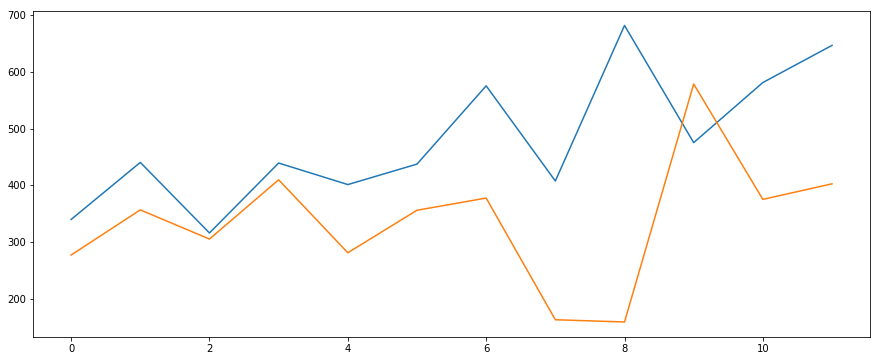

In [15]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

<b>Resumo</b>

- Como preparar dados de séries temporais para desenvolver um modelo LSTM.
- Como desenvolver um modelo LSTM para previsão de séries temporais.
- Como avaliar um modelo LSTM usando um chicote de teste robusto.